In [765]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import pickle
import sys
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sys.path.append('/Users/SoapyGenie/Dropbox/Documentos/Estudios/Master IA/Mineria 2')

# Cargo las funciones que voy a utilizar
from FuncionesMineria import (analizar_variables_categoricas, cuentaDistintos, frec_variables_num, atipicosAmissing, 
                              patron_perdidos, ImputacionCuant, ImputacionCuali, graficoVcramer, mosaico_targetbinaria,
                              boxplot_targetbinaria, hist_targetbinaria, Transf_Auto, lm, Rsq, validacion_cruzada_lm,
                              modelEffectSizes, crear_data_modelo, Vcramer, lm_forward, lm_backward, lm_stepwise,
                              glm, summary_glm, validacion_cruzada_glm, pseudoR2, impVariablesLog, curva_roc, sensEspCorte, glm_stepwise, glm_backward)

# Cargar el conjunto de datos
datos = sns.load_dataset('penguins')

# Ver las primeras filas del dataset
print(datos.head())


  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      342.000000     342.000000         342.000000   342.000000
mean        43.921930      17.151170         200.915205  4201.754386
std          5.459584       1.974793          14.061714   801.954536
min         32.100000      13.100000         172.000000  2700.000000
25%         39.225000      15.600000         190.000000  3550.000000
50%         44.450000      17.300000         197.000000  4050.000000
75%         48.500000      18.700000         213.000000  4750.000000
max         59.600000      21.500000         231.000000  6300.000000


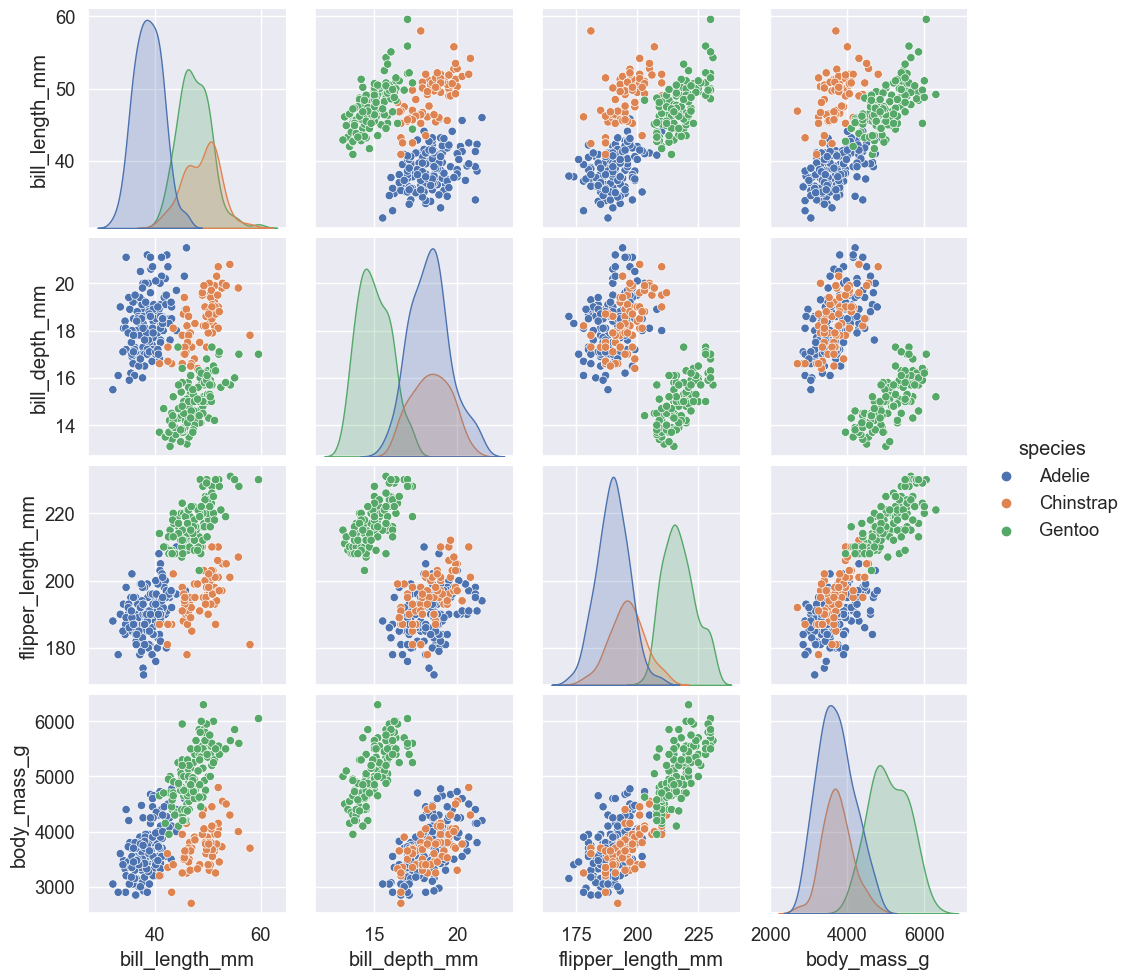

In [766]:

# Estadísticas descriptivas
print(datos.describe())

# Visualizaciones básicas
sns.pairplot(datos, hue='species')
plt.show()


In [767]:
# Genera una lista con los nombres de las variables.
variables = list(datos.columns)
variables

['species',
 'island',
 'bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'body_mass_g',
 'sex']

In [768]:
variables = list(datos.columns)  
numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns
categoricas = [variable for variable in variables if variable not in numericas]

datos.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

In [769]:
# Frecuencias de los valores en las variables categóricas
analizar_variables_categoricas(datos)

{'species':              n         %
 Adelie     152  0.441860
 Gentoo     124  0.360465
 Chinstrap   68  0.197674,
 'island':              n         %
 Biscoe     168  0.488372
 Dream      124  0.360465
 Torgersen   52  0.151163,
 'sex':           n         %
 Male    168  0.504505
 Female  165  0.495495}

In [770]:
cuentaDistintos(datos)

,Columna,Distintos
0,bill_length_mm,165
1,bill_depth_mm,81
2,flipper_length_mm,56
3,body_mass_g,95


In [771]:
# Descriptivos variables numéricas mediante función describe() de Python
descriptivos_num = datos.describe().T
# Añadimos más descriptivos a los anteriores
for num in numericas:
    descriptivos_num.loc[num, "Asimetria"] = datos[num].skew()
    descriptivos_num.loc[num, "Kurtosis"] = datos[num].kurtosis()
    descriptivos_num.loc[num, "Mediana"] = datos[num].median()
    descriptivos_num.loc[num, "Rango"] = np.ptp(datos[num].dropna().values)
descriptivos_num

,count,mean,std,min,25%,50%,75%,max,Asimetria,Kurtosis,Mediana,Rango
bill_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6,0.053118,-0.876027,44.45,27.5
bill_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5,-0.143465,-0.906866,17.30,8.4
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0,0.345682,-0.984273,197.00,59.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0,0.470329,-0.719222,4050.00,3600.0


In [772]:
# Muestra valores perdidos
datos[variables].isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [773]:
# Indico la variableObj, el ID y las Input (los atipicos y los missings se gestionan
# solo de las variables input)
#datos = datos.set_index(datos['Name']).drop('Name', axis = 1)
#varObjCont = datos['AbstentionPtge']
#varObjBin = datos['AbstencionAlta']
datos_input = datos#.drop(['AbstentionPtge', 'AbstencionAlta','Name'], axis = 1)
numericas_input = datos_input.select_dtypes(include = ['int', 'int32', 'int64','float', 'float32', 'float64']).columns
variables_input = list(datos_input.columns)  
categoricas_input = [variable for variable in variables_input if variable not in numericas_input]

In [774]:
resultados = {x: atipicosAmissing(datos_input[x])[1] / len(datos_input) for x in numericas_input}
resultados

{'bill_length_mm': 0.0,
 'bill_depth_mm': 0.0,
 'flipper_length_mm': 0.0,
 'body_mass_g': 0.0}

In [775]:
# Modifico los atipicos como missings
for x in numericas_input:
    datos_input[x] = atipicosAmissing(datos_input[x])[0]

In [776]:
# Creamos la variable prop_missings que recoge el número de valores perdidos por cada observación
# es la cantidad de variables que estan en nan por cada registro
datos_input['prop_missings'] = datos_input.isna().mean(axis = 1)
datos_input

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,prop_missings
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0.000000
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0.000000
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0.000000
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,0.714286
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0.000000
...,...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN,0.714286
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,0.000000
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,0.000000
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,0.000000


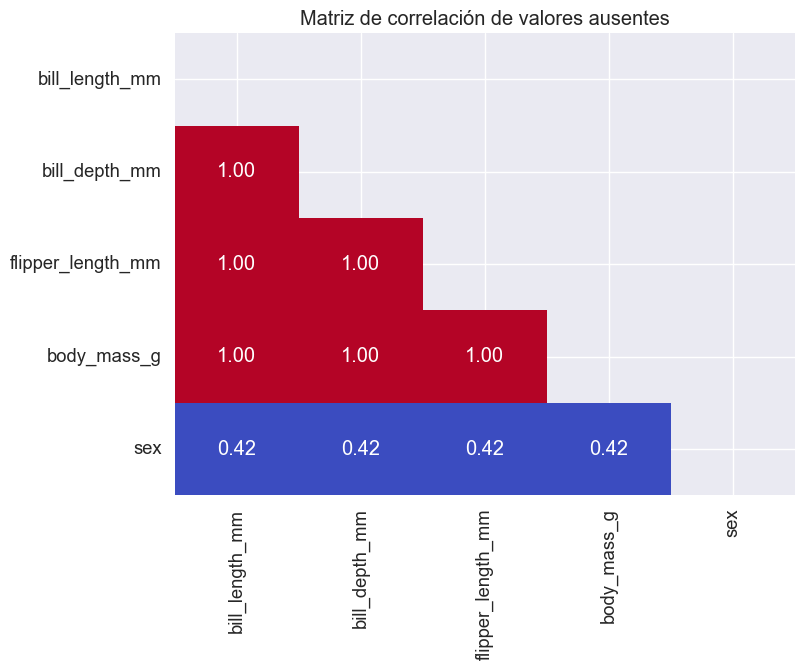

In [777]:
# MISSINGS
# Visualiza un mapa de calor que muestra la matriz de correlación de valores ausentes en el conjunto de datos.
# mas rojo mas perdidos
patron_perdidos(datos_input)

In [778]:
# Muestra proporción de valores perdidos por cada variable (guardo la información)
prop_missingsVars = datos_input.isna().sum()/len(datos_input)
prop_missingsVars

species              0.000000
island               0.000000
bill_length_mm       0.005814
bill_depth_mm        0.005814
flipper_length_mm    0.005814
body_mass_g          0.005814
sex                  0.031977
prop_missings        0.000000
dtype: float64

In [779]:
# Elimino las observaciones con mas de la mitad de datos missings (no hay ninguna)
eliminar = datos_input['prop_missings'] > 0.5
datos_input = datos_input[~eliminar]

# Elimino las variables con mas de la mitad de datos missings (no hay ninguna)
# lo mismo pero en las filas os ea las variables
eliminar = [prop_missingsVars.index[x] for x in range(len(prop_missingsVars)) if prop_missingsVars[x] > 0.5]
datos_input = datos_input.drop(eliminar, axis = 1)

#datos_input.isna().mean(axis = 1).unique()

In [780]:
## IMPUTACIONES
# Imputo todas las cuantitativas, seleccionar el tipo de imputacion: media, mediana o aleatorio
# esto lo que hace es que a las NaN de aqui les pone un valor aleatorio pero siguiendo la distribucion con el objetivo de no perder el valor de las demas variables
for x in numericas_input:
    datos_input[x] = ImputacionCuant(datos_input[x], 'aleatorio')

In [781]:
# Imputo todas las cualitativas, seleccionar el tipo de imputacion: moda o aleatorio
for x in categoricas_input:
    datos_input[x] = ImputacionCuali(datos_input[x], 'aleatorio')

In [782]:
# Reviso que no queden datos missings
datos_input.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
prop_missings        0
dtype: int64

<Axes: >

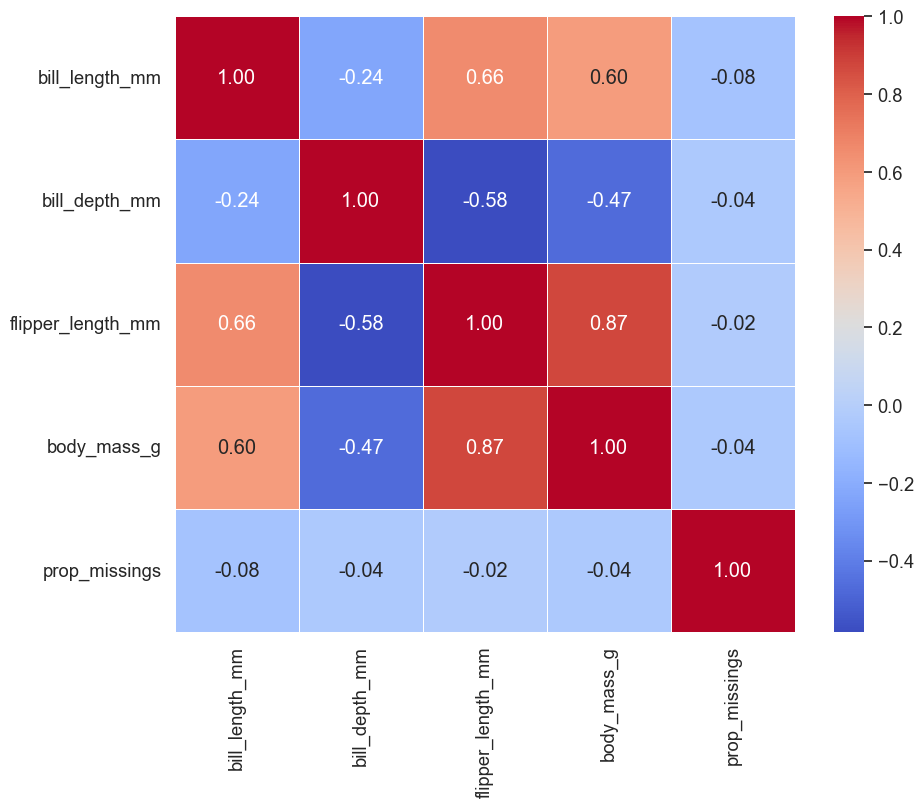

In [783]:
R = datos_input.corr()
plt.figure(figsize = (10,8))
sns.heatmap(R, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [784]:
# Estandarizamos los datos:
# datos_estandarizadas = StandardScaler().fit_transform(datos_input[numericas_input])

datos_estandarizadas = pd.DataFrame(
    StandardScaler().fit_transform(datos_input[numericas_input]),  # Datos estandarizados
    columns=['{}_z'.format(variable) for variable in numericas],  # Nombres de columnas estandarizadas
    index=datos_input[numericas_input].index  # Índices (etiquetas de filas) del DataFrame
)

datos_estandarizadas

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
4,-1.324737,1.089724,-0.563715,-0.938776
5,-0.847812,1.748985,-0.777373,-0.689020
...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175
340,0.527932,-1.445897,1.003109,0.809516
341,1.188289,-0.735923,1.501644,1.933419
342,0.234440,-1.192335,0.789451,1.246590


In [785]:
# Crea una instancia de An ́alisis de Componentes Principales (ACP):
# - Utilizamos PCA(n_components=7) para crear un objeto PCA que realizar ́aun an ́alisis de componentes principales.
# - Establecemos n_components en 7 para retener el maximo de lascomponentes principales (maximo= numero de variables).
pca = PCA(n_components=4)
fit = pca.fit(datos_estandarizadas)
# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_
# Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
var_explicada = fit.explained_variance_ratio_*100
# Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
var_acumulada = np.cumsum(var_explicada)
# Crear un DataFrame de pandas con los datos anteriores y establecer  ́ındice .
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada , 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range (1, fit.n_components_+1)])
tabla

,Autovalores,Variabilidad Explicada,Variabilidad Acumulada
Componente 1,2.761831,68.843878,68.843878
Componente 2,0.774782,19.312919,88.156797
Componente 3,0.366307,9.130898,97.287695
Componente 4,0.108810,2.712305,100.000000


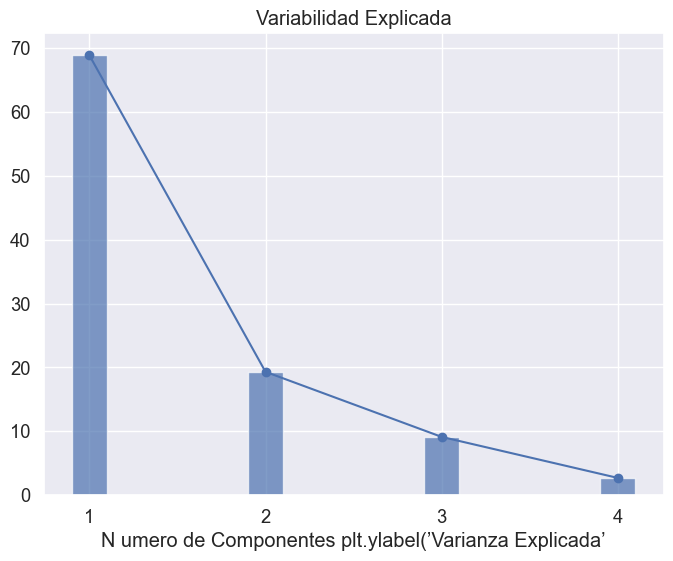

In [786]:
# Representacion de la variabilidad explicada: #Creamos la funci ́on plot_varianza_explicada
#Args:
#var_explicada (array): Un array que contiene el porcentaje devarianza explicada
#por cada componente principal. Generalmente calculado como #var_explicada = fit.explained_variance_ratio_ * 100.
#n_components (int): El n ́umero total de componentes principales. #Generalmente calculado como fit.n_components.
def plot_varianza_explicada(var_explicada , n_components):
# Crear un rango de n ́umeros de componentes principales de 1 an_components
    num_componentes_range = np.arange(1, n_components + 1)
    plt.figure(figsize=(8, 6))
    # Trazar la varianza explicada en funci ́on del n ́umero de componentes principales
    plt.plot(num_componentes_range , var_explicada , marker='o')
    # Etiquetas de los ejes x e y
    plt.xlabel('N umero de Componentes plt.ylabel(’Varianza Explicada’')
    # T ́ıtulo del gr ́afico
    plt.title('Variabilidad Explicada')
    # Establecer las marcas en el eje componentes
    plt.xticks(num_componentes_range)
    # Mostrar una cuadr ́ıcula en el gr ́afico
    plt.grid(True)
    # Agregar barras debajo de cada punto para representar el porcentaje de variabilidad explicada
    # - ’width’: Ancho de las barras de la barra. En este caso, se establece en 0.2 unidades.
    # - ’align’: Alineaci ́on de las barras con respecto a los puntos en el eje x.
    # ’center’ significa que las barras estar ́an centradas debajo de los puntos.
    # - ’alpha’: Transparencia de las barras. Un valor de 0.7 significa que las barras son 70% transparentes.
    plt.bar(num_componentes_range , var_explicada , width=0.2, align='center'
    , alpha =0.7)
    # Mostrar el gr ́afico
    plt.show()
plot_varianza_explicada(var_explicada , fit.n_components_)

In [787]:
variables

['species',
 'island',
 'bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'body_mass_g',
 'sex']

In [788]:
print(datos_estandarizadas.shape)

(342, 4)


In [789]:
['{}_z'.format(variable) for variable in variables]

['species_z',
 'island_z',
 'bill_length_mm_z',
 'bill_depth_mm_z',
 'flipper_length_mm_z',
 'body_mass_g_z',
 'sex_z']

In [790]:
['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)]

['Autovector 1', 'Autovector 2', 'Autovector 3', 'Autovector 4']

In [791]:
pca = PCA(n_components=2)
fit = pca.fit(datos_estandarizadas)
pca.components_.T

array([[ 0.45525033,  0.59703114],
       [-0.40033468,  0.79776657],
       [ 0.57601332,  0.0022822 ],
       [ 0.54835019,  0.08436292]])

In [792]:
datos_estandarizadas

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
4,-1.324737,1.089724,-0.563715,-0.938776
5,-0.847812,1.748985,-0.777373,-0.689020
...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175
340,0.527932,-1.445897,1.003109,0.809516
341,1.188289,-0.735923,1.501644,1.933419
342,0.234440,-1.192335,0.789451,1.246590


In [793]:
# # Crea una instancia de ACP con las dos primeras componentes que nos interesan y aplicar a los datos.
# datos_beta = datos_estandarizadas.copy

# datos_beta['species'] = datos_input[['species']]
# gentoo_data = datos_beta[datos_beta['species'] == 'Gentoo']
# gentoo_data = gentoo_data.drop('species', axis=1)
# gentoo_data


In [794]:

# pca = PCA(n_components=2)
# fit = pca.fit(gentoo_data)
# # Obtener los autovectores asociados a cada componente principal y transponerlos.
# autovectores = pd.DataFrame(pca.components_.T, 
#                             columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
#                             index = ['{}_z'.format(variable) for variable in numericas])

# # Obtener los autovalores asociados a cada componente principal.
# autovalores = fit.explained_variance_
# # Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
# var_explicada = fit.explained_variance_ratio_*100
# # Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
# var_acumulada = np.cumsum(var_explicada)
# # Crear un DataFrame de pandas con los datos anteriores y establecer  ́ındice .
# data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada , 'Variabilidad Acumulada': var_acumulada}
# tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range (1, fit.n_components_+1)])
# tabla

# autovectores

In [795]:
# datos_beta = datos_estandarizadas.copy

# datos_beta['species'] = datos_input[['species']]
# adelie_data = datos_beta[datos_beta['species'] == 'Adelie']
# adelie_data = adelie_data.drop('species', axis=1)


# pca = PCA(n_components=2)
# fit = pca.fit(adelie_data)
# # Obtener los autovectores asociados a cada componente principal y transponerlos.
# autovectores = pd.DataFrame(pca.components_.T, 
#                             columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
#                             index = ['{}_z'.format(variable) for variable in numericas])

# # Obtener los autovalores asociados a cada componente principal.
# autovalores = fit.explained_variance_
# # Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
# var_explicada = fit.explained_variance_ratio_*100
# # Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
# var_acumulada = np.cumsum(var_explicada)
# # Crear un DataFrame de pandas con los datos anteriores y establecer  ́ındice .
# data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada , 'Variabilidad Acumulada': var_acumulada}
# tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range (1, fit.n_components_+1)])
# tabla

# autovectores

In [796]:
# datos_beta = datos_estandarizadas.copy

# datos_beta['species'] = datos_input[['species']]
# chinstrap_data = datos_beta[datos_beta['species'] == 'Chinstrap']
# chinstrap_data = chinstrap_data.drop('species', axis=1)

# pca = PCA(n_components=2)
# fit = pca.fit(chinstrap_data)
# # Obtener los autovectores asociados a cada componente principal y transponerlos.
# autovectores = pd.DataFrame(pca.components_.T, 
#                             columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
#                             index = ['{}_z'.format(variable) for variable in numericas])

# # Obtener los autovalores asociados a cada componente principal.
# autovalores = fit.explained_variance_
# # Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
# var_explicada = fit.explained_variance_ratio_*100
# # Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
# var_acumulada = np.cumsum(var_explicada)
# # Crear un DataFrame de pandas con los datos anteriores y establecer  ́ındice .
# data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada , 'Variabilidad Acumulada': var_acumulada}
# tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range (1, fit.n_components_+1)])
# tabla

# autovectores

In [797]:
# Crea una instancia de ACP con las dos primeras componentes que nos interesan y aplicar a los datos.
pca = PCA(n_components=2)
fit = pca.fit(datos_estandarizadas)
# Obtener los autovectores asociados a cada componente principal y transponerlos.
autovectores = pd.DataFrame(pca.components_.T, 
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in numericas])

# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_
# Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
var_explicada = fit.explained_variance_ratio_*100
# Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
var_acumulada = np.cumsum(var_explicada)
# Crear un DataFrame de pandas con los datos anteriores y establecer  ́ındice .
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada , 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range (1, fit.n_components_+1)])
tabla

autovectores

,Autovector 1,Autovector 2
bill_length_mm_z,0.455250,0.597031
bill_depth_mm_z,-0.400335,0.797767
flipper_length_mm_z,0.576013,0.002282
body_mass_g_z,0.548350,0.084363


In [798]:
resultados_pca = pd.DataFrame(fit.transform(datos_estandarizadas), 
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=datos_estandarizadas.index)

notas_z_cp = pd.concat([datos_estandarizadas , resultados_pca], axis=1) 
variables_cp = notas_z_cp.columns

In [799]:
# C ́alculo de las correlaciones entre las variables originales y las componentes seleccionadas.
# Guardamos el nombre de las variables del archivo conjunto (variables y componentes).
variables_cp = notas_z_cp.columns
# Calculamos las correlaciones y seleccionamos las que nos interesan ( variables contra componentes).
correlacion = pd.DataFrame(np.corrcoef(datos_estandarizadas.T, resultados_pca.T),
index = variables_cp , columns = variables_cp)
n_variables = fit.n_features_
correlaciones_notas_con_cp = correlacion.iloc[:fit.n_features_ , fit.n_features_:]

In [800]:
cos2 = correlaciones_notas_con_cp **2
cos2

,Componente 1,Componente 2
bill_length_mm_z,0.570724,0.275361
bill_depth_mm_z,0.441338,0.491654
flipper_length_mm_z,0.913672,0.000004
body_mass_g_z,0.828021,0.005498


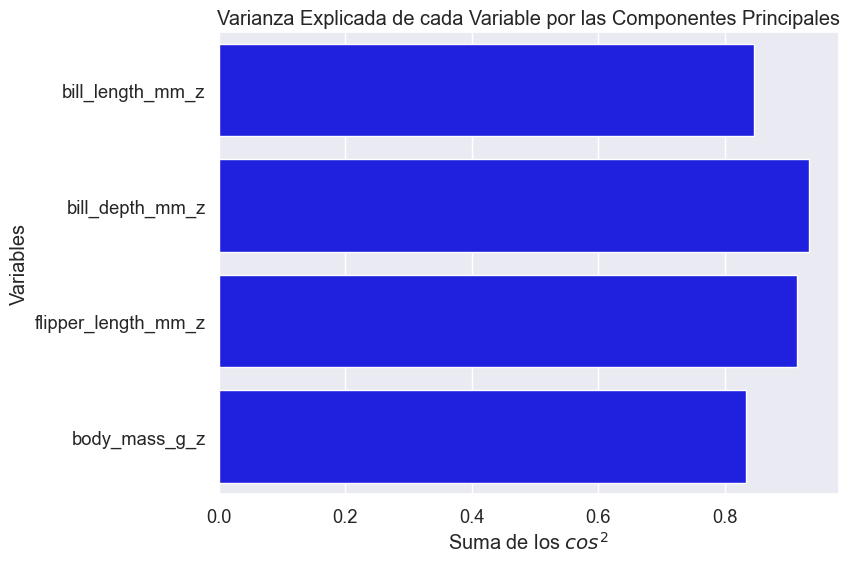

In [801]:
def plot_cos2_bars(cos2):
    """
    Genera un gráfico de barras para representar la varianza explicada de cada variable utilizando los cuadrados de las cargas (cos^2).

    Args:
        cos2 (pd.DataFrame): DataFrame que contiene los cuadrados de las cargas de las variables en las componentes principales.

    Returns:
        None
    """
    # Crea una figura de tamaño 8x6 pulgadas para el gráfico
    plt.figure(figsize=(8, 6))

    # Crea un gráfico de barras para representar la varianza explicada por cada variable
    sns.barplot(x=cos2.sum(axis=1), y=cos2.index, color="blue")

    # Etiqueta los ejes
    plt.xlabel('Suma de los $cos^2$')
    plt.ylabel('Variables')

    # Establece el título del gráfico
    plt.title('Varianza Explicada de cada Variable por las Componentes Principales')

    # Muestra el gráfico
    plt.show()
    

plot_cos2_bars(cos2)

#validacion, si es mayor a 0.8 es que esta bien

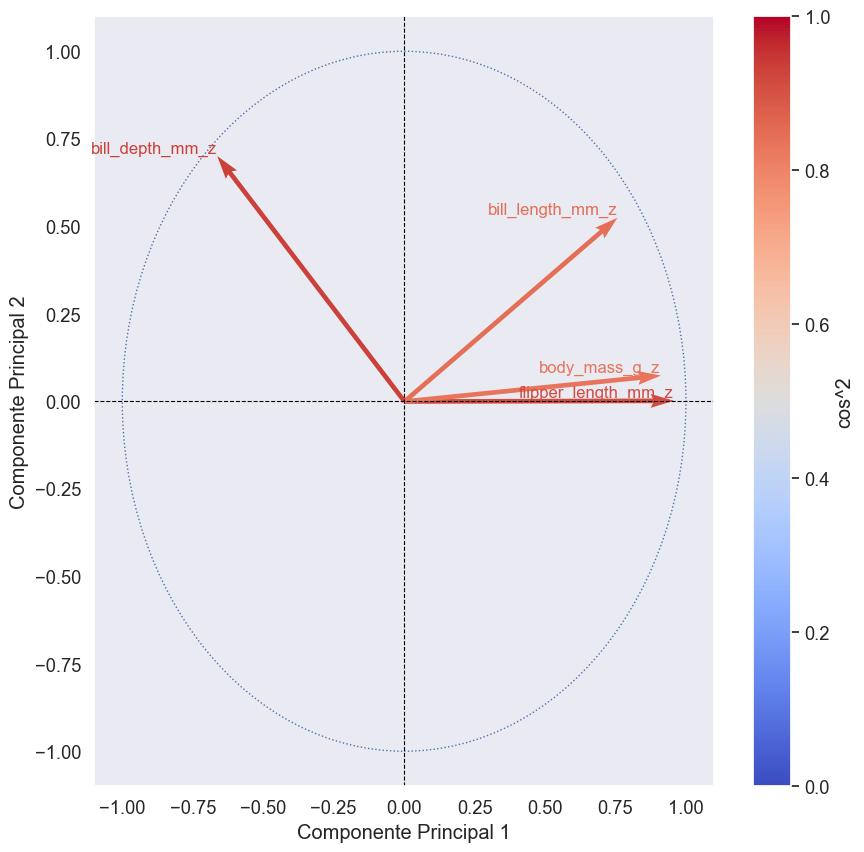

In [802]:
def plot_corr_cos(n_components, correlaciones_datos_con_cp):
    """
    Genera un gráficos en los que se representa un vector por cada variable, usando como ejes las componentes, la orientación
    y la longitud del vector representa la correlación entre cada variable y dos de las componentes. El color representa el
    valor de la suma de los cosenos al cuadrado.

    Args:
        n_components (int): Número entero que representa el número de componentes principales seleccionadas.
        correlaciones_datos_con_cp (DataFrame): DataFrame que contiene la matriz de correlaciones entre variables y componentes
    """
    # Definir un mapa de color (cmap) sensible a las diferencias numéricas

    cmap = plt.get_cmap('coolwarm')  # Puedes ajustar el cmap según tus preferencias


    for i in range(n_components):
        for j in range(i + 1, n_components):  # Evitar pares duplicados
            # Calcular la suma de los cosenos al cuadrado
            sum_cos2 = correlaciones_datos_con_cp.iloc[:, i] ** 2 + correlaciones_datos_con_cp.iloc[:, j] ** 2

            # Crear un nuevo gráfico para cada par de componentes principales
            plt.figure(figsize=(10, 10))

            # Dibujar un círculo de radio 1
            circle = plt.Circle((0, 0), 1, fill=False, color='b', linestyle='dotted')

            plt.gca().add_patch(circle)

            # Dibujar vectores para cada variable con colores basados en la suma de los cosenos al cuadrado
            for k, var_name in enumerate(correlaciones_datos_con_cp.index):
                x = correlaciones_datos_con_cp.iloc[k, i]  # Correlación en la primera dimensión
                y = correlaciones_datos_con_cp.iloc[k, j]  # Correlación en la segunda dimensión

                # Seleccionar un color de acuerdo a la suma de los cosenos al cuadrado
                color = cmap(sum_cos2[k])

                # Dibujar el vector con el color seleccionado
                plt.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=color)

                # Agregar el nombre de la variable junto a la flecha con el mismo color
                plt.text(x, y, var_name, color=color, fontsize=12, ha='right', va='bottom')

            # Dibujar líneas discontinuas que representen los ejes
            plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
            plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

            # Etiquetar los ejes
            plt.xlabel(f'Componente Principal {i + 1}')
            plt.ylabel(f'Componente Principal {j + 1}')

            # Establecer los límites del gráfico
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)

            # Agregar un mapa de color (colorbar) y su leyenda
            sm = plt.cm.ScalarMappable(cmap=cmap)
            sm.set_array([])  # Evita errores de escala
            plt.colorbar(mappable=sm, orientation='vertical', label='cos^2')  # Agrega la leyenda
            # Mostrar el gráfico
            plt.grid()
            plt.show()
            
plot_corr_cos(fit.n_components, correlaciones_notas_con_cp)

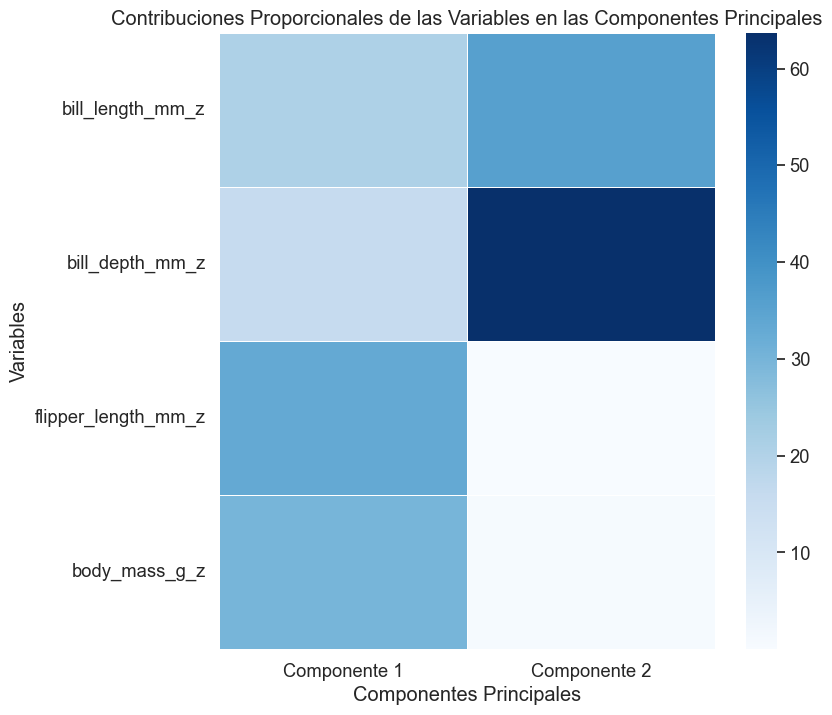

In [803]:
def plot_contribuciones_proporcionales(cos2, autovalores, n_components):
    """
    Cacula las contribuciones de cada variable a las componentes principales y
    Genera un gráfico de mapa de calor con los datos
    Args:
        cos2 (DataFrame): DataFrame de los cuadrados de las cargas (cos^2).
        autovalores (array): Array de los autovalores asociados a las componentes principales.
        n_components (int): Número de componentes principales seleccionadas.
    """
    # Calcula las contribuciones multiplicando cos2 por la raíz cuadrada de los autovalores
    contribuciones = cos2 * np.sqrt(autovalores)

    # Inicializa una lista para las sumas de contribuciones
    sumas_contribuciones = []

    # Calcula la suma de las contribuciones para cada componente principal
    for i in range(n_components):
        nombre_componente = f'Componente {i + 1}'
        suma_contribucion = np.sum(contribuciones[nombre_componente])
        sumas_contribuciones.append(suma_contribucion)

    # Calcula las contribuciones proporcionales dividiendo por las sumas de contribuciones
    contribuciones_proporcionales = contribuciones.div(sumas_contribuciones, axis=1) * 100

    # Crea una figura de tamaño 8x8 pulgadas para el gráfico
    plt.figure(figsize=(8, 8))

    # Utiliza un mapa de calor (heatmap) para visualizar las contribuciones proporcionales
    sns.heatmap(contribuciones_proporcionales, cmap='Blues', linewidths=0.5, annot=False)

    # Etiqueta los ejes (puedes personalizar los nombres de las filas y columnas si es necesario)
    plt.xlabel('Componentes Principales')
    plt.ylabel('Variables')

    # Establece el título del gráfico
    plt.title('Contribuciones Proporcionales de las Variables en las Componentes Principales')

    # Muestra el gráfico
    plt.show()
    
    # Devuelve los DataFrames de contribuciones y contribuciones proporcionales
    return contribuciones_proporcionales

contribuciones_proporcionales = plot_contribuciones_proporcionales(cos2,autovalores,fit.n_components)

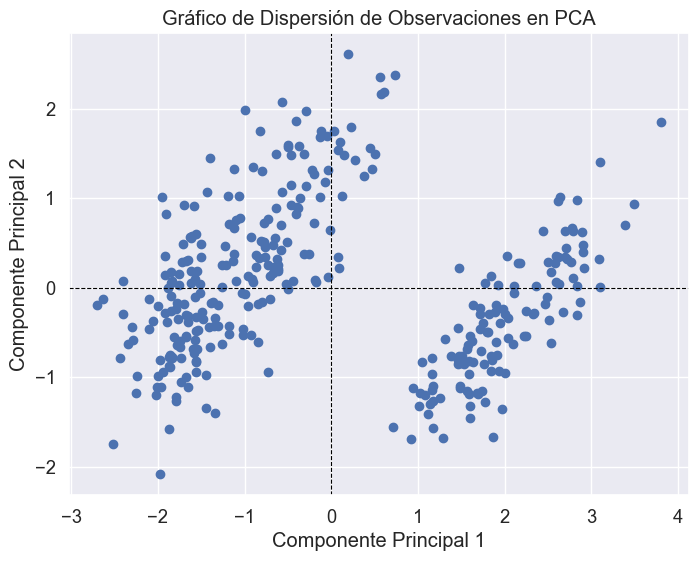

In [804]:
def plot_pca_scatter(pca, datos_estandarizados, n_components):
    """
    Genera gráficos de dispersión de observaciones en pares de componentes principales seleccionados.

    Args:
        pca (PCA): Objeto PCA previamente ajustado.
        datos_estandarizados (pd.DataFrame): DataFrame de datos estandarizados.
        n_components (int): Número de componentes principales seleccionadas.
    """
    # Representamos las observaciones en cada par de componentes seleccionadas
    componentes_principales = pca.transform(datos_estandarizados)
    
    for i in range(n_components):
        for j in range(i + 1, n_components):  # Evitar pares duplicados
            # Calcular la suma de los valores al cuadrado para cada variable
            # Crea un gráfico de dispersión de las observaciones en las dos primeras componentes principales
            plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
            plt.scatter(componentes_principales[:, i], componentes_principales[:, j])
            
            # Añade etiquetas a las observaciones
            # etiquetas_de_observaciones = list(datos_estandarizados.index)
    
            # for k, label in enumerate(etiquetas_de_observaciones):
            #     plt.annotate(label, (componentes_principales[k, i], componentes_principales[k, j]))
            
            # Dibujar líneas discontinuas que representen los ejes
            plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
            plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
            
            # Etiquetar los ejes
            plt.xlabel(f'Componente Principal {i + 1}')
            plt.ylabel(f'Componente Principal {j + 1}')
            
            # Establece el título del gráfico
            plt.title('Gráfico de Dispersión de Observaciones en PCA')
            
            plt.show()
            
plot_pca_scatter(pca, datos_estandarizadas, fit.n_components)

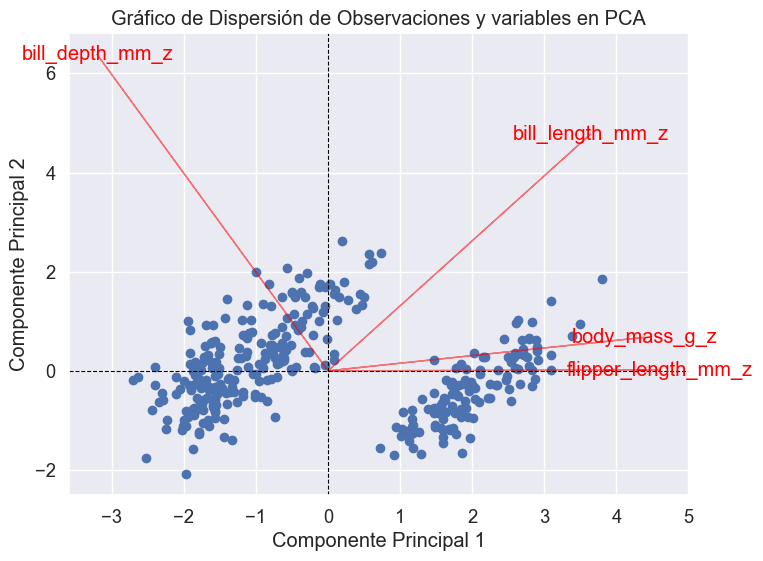

In [805]:
def plot_pca_scatter_with_vectors(pca, datos_estandarizados, n_components, components_):
    """
    Genera gráficos de dispersión de observaciones en pares de componentes principales seleccionados
    con vectores de las correlaciones escaladas entre variables y componentes

    Args:
        pca (PCA): Objeto PCA previamente ajustado.
        datos_estandarizados (pd.DataFrame): DataFrame de datos estandarizados.
        n_components (int): Número de componentes principales seleccionadas.
        components_: Array con las componentes.
    """
    # Representamos las observaciones en cada par de componentes seleccionadas
    componentes_principales = pca.transform(datos_estandarizados)
    
    for i in range(n_components):
        for j in range(i + 1, n_components):  # Evitar pares duplicados
            # Calcular la suma de los valores al cuadrado para cada variable
            # Crea un gráfico de dispersión de las observaciones en las dos primeras componentes principales
            plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
            plt.scatter(componentes_principales[:, i], componentes_principales[:, j])
            
            # Añade etiquetas a las observaciones
            # etiquetas_de_observaciones = list(datos_estandarizados.index)
    
            # for k, label in enumerate(etiquetas_de_observaciones):
            #     plt.annotate(label, (componentes_principales[k, i], componentes_principales[k, j]))
            
            # Dibujar líneas discontinuas que representen los ejes
            plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
            plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
            
            # Etiquetar los ejes
            plt.xlabel(f'Componente Principal {i + 1}')
            plt.ylabel(f'Componente Principal {j + 1}')
            
            # Establece el título del gráfico
            plt.title('Gráfico de Dispersión de Observaciones y variables en PCA')
            
            
            # Añadimos vectores que representen las correlaciones escaladas entre variables y componentes
            fit = pca.fit(datos_estandarizados)
            coeff = np.transpose(fit.components_)
            scaled_coeff = 8 * coeff  #8 = escalado utilizado, ajustar en función del ejemplo
            for var_idx in range(scaled_coeff.shape[0]):
                plt.arrow(0, 0, scaled_coeff[var_idx, i], scaled_coeff[var_idx, j], color='red', alpha=0.5)
                plt.text(scaled_coeff[var_idx, i], scaled_coeff[var_idx, j],
                     datos_estandarizadas.columns[var_idx], color='red', ha='center', va='center')
            
            plt.show()
            
plot_pca_scatter_with_vectors(pca, datos_estandarizadas, fit.n_components, fit.components_)

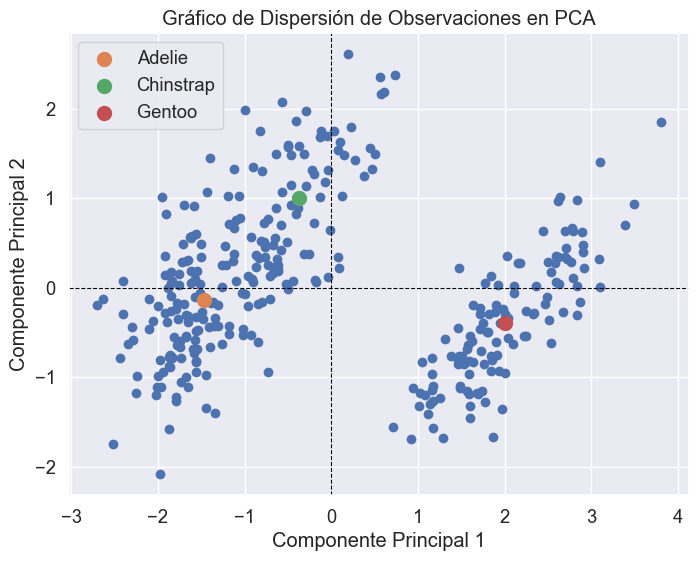

In [806]:
def plot_pca_scatter_with_categories(datos_componentes_sup_var, componentes_principales_sup, n_components, var_categ):
    """
    Genera gráficos de dispersión de observaciones en pares de componentes principales seleccionados con categorías.

    Args:
        datos_componentes_sup_var (pd.DataFrame): DataFrame que contiene las categorías.
        componentes_principales_sup (np.ndarray): Matriz de componentes principales.
        n_components (int): Número de componentes principales seleccionadas.
        var_categ (str): Nombre de la variable introducida
    """
    # Obtener las categorías únicas
    categorias = datos_componentes_sup_var[var_categ].unique() #Modificar por el nombre de la variable categórica

    for i in range(n_components):
        for j in range(i + 1, n_components):  # Evitar pares duplicados
            # Crear un gráfico de dispersión de las observaciones en las dos primeras componentes principales
            plt.figure(figsize=(8, 6))  # Ajustar el tamaño de la figura si es necesario
            plt.scatter(componentes_principales_sup[:, i], componentes_principales_sup[:, j])

            for categoria in categorias:
                # Filtrar las observaciones por categoría
                observaciones_categoria = componentes_principales_sup[datos_componentes_sup_var[var_categ] == categoria]
                # Calcular el centroide de la categoría
                centroide = np.mean(observaciones_categoria, axis=0)
                plt.scatter(centroide[i], centroide[j], label=categoria, s=100, marker='o')

            # Añadir etiquetas a las observaciones
            # etiquetas_de_observaciones = list(datos_componentes_sup_var.index)

            # for k, label in enumerate(etiquetas_de_observaciones):
            #     plt.annotate(label, (componentes_principales_sup[k, i], componentes_principales_sup[k, j]))
            #     # Dibujar líneas discontinuas que representen los ejes

            # Dibujar líneas discontinuas que representen los ejes
            plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
            plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

            # Etiquetar los ejes
            plt.xlabel(f'Componente Principal {i + 1}')
            plt.ylabel(f'Componente Principal {j + 1}')

            # Establecer el título del gráfico
            plt.title('Gráfico de Dispersión de Observaciones en PCA')

            # Mostrar la leyenda para las categorías
            plt.legend()
            plt.show()
            
data_componentes_sup = pd.concat([ datos_estandarizadas , resultados_pca ] , axis =1)
componentes_principales = pca.transform(datos_estandarizadas)

plot_pca_scatter_with_categories(datos_input, componentes_principales, fit.n_components, 'species')

In [807]:
datos_input

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,prop_missings
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0.0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0.0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0.0
...,...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female,0.0
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female,0.0
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male,0.0
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female,0.0


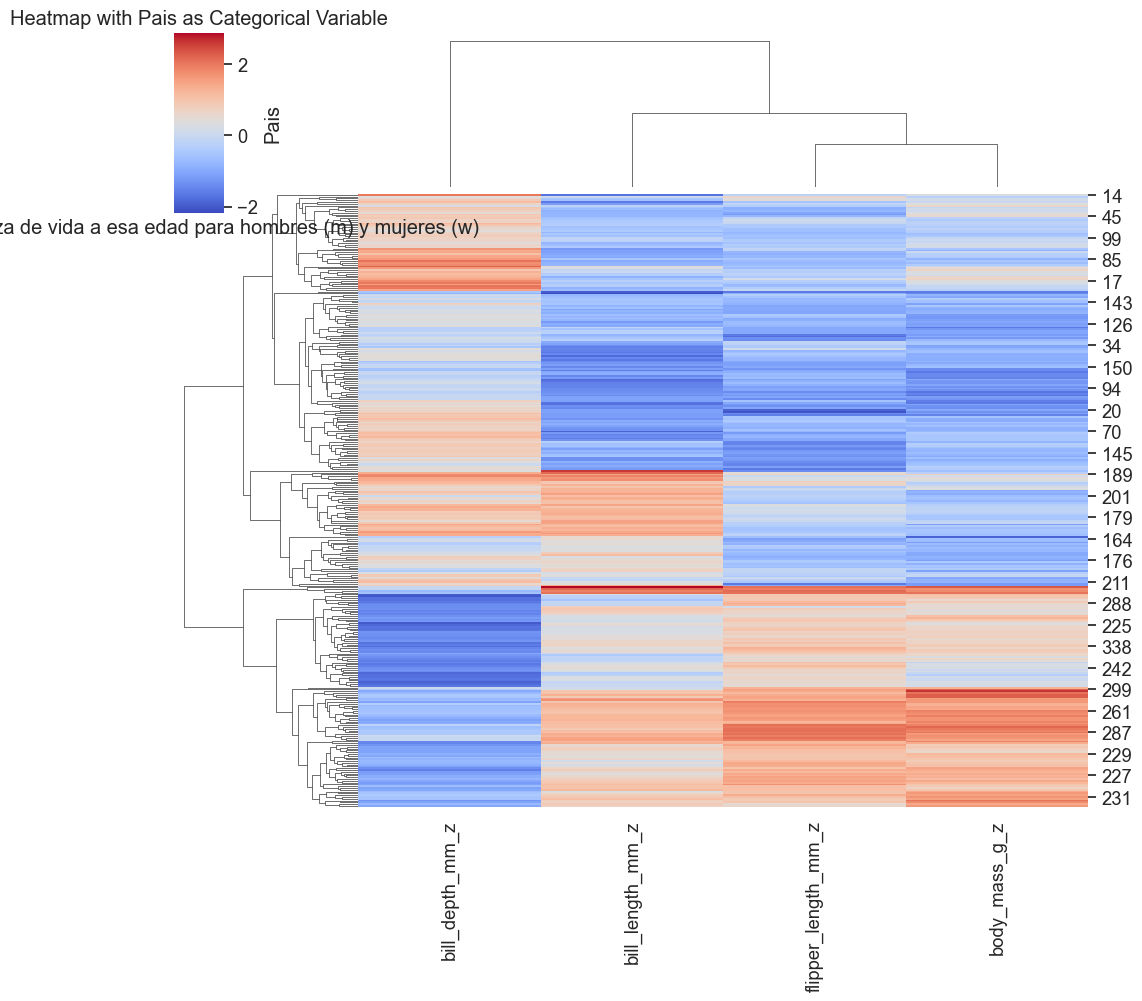

In [808]:

sns.clustermap(datos_estandarizadas, cmap='coolwarm', annot=False)

plt.title('Heatmap with Pais as Categorical Variable')
plt.xlabel('Esperanza de vida a esa edad para hombres (m) y mujeres (w)')
plt.ylabel('Pais')
# Display the plot
plt.show()

# agrupa para las observaciones y las variables


In [809]:
from scipy.spatial import distance
# Calculate the pairwise Euclidean distances
distance_matrix = distance.cdist(datos_estandarizadas, datos_estandarizadas, 'euclidean')
# The distance_matrix is a 2D array containing the Euclidean distances between all pairs of observations.
distance_small = distance_matrix[:5, :5]
#Index are added to the distance matrix
distance_small = pd.DataFrame(distance_small , index=datos_estandarizadas.index
[:5], columns=datos_estandarizadas.index[:5])
distance_small_rounded = distance_small.round(2)
distance_small_rounded.head()

,0,1,2,4,5
0,0.00,0.76,1.25,1.08,1.16
1,0.76,0.00,1.00,1.28,1.66
2,1.25,1.00,0.00,0.98,1.47
4,1.08,1.28,0.98,0.00,0.88
5,1.16,1.66,1.47,0.88,0.00


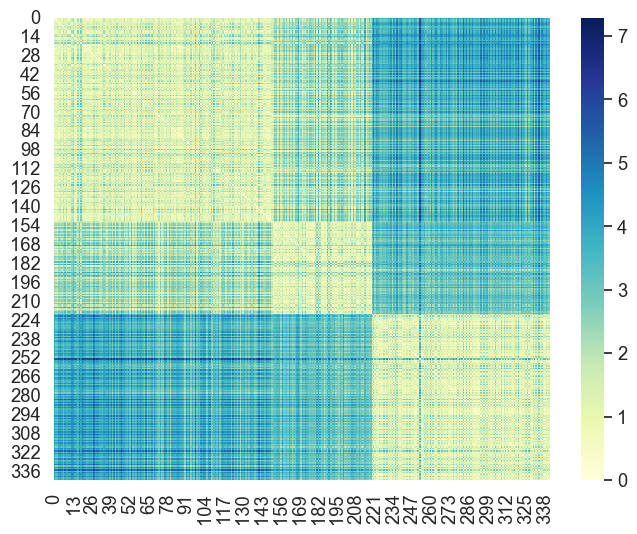

In [810]:
plt.figure(figsize=(8, 6))
sns.heatmap(distance_matrix , annot=False , cmap="YlGnBu", fmt=".1f") 
plt.show()

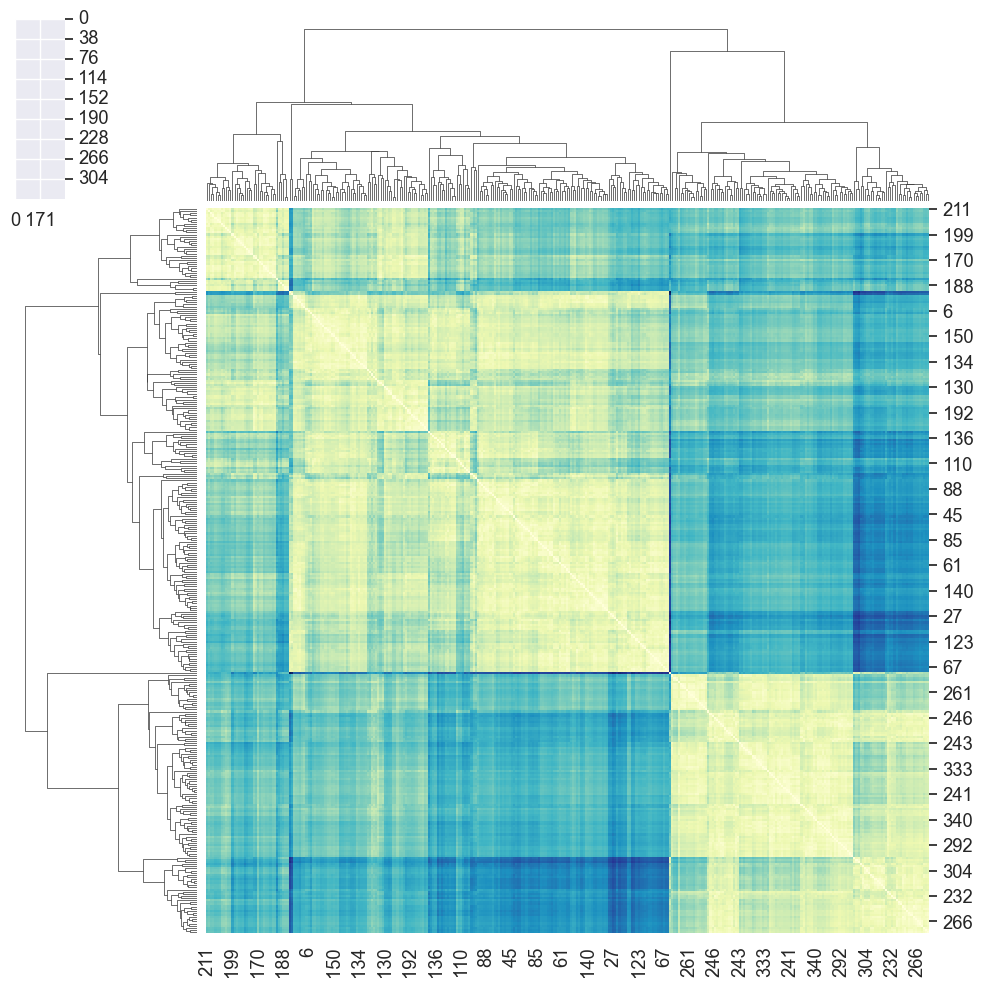

In [811]:
# Perform hierarchical clustering to get the linkage matrix
linkage = sns.clustermap(distance_matrix , cmap="YlGnBu", fmt=".1f", annot=False, method='average').dendrogram_row.linkage
# Reorder the data based on the hierarchical clustering
order = pd.DataFrame(linkage, columns=['cluster_1', 'cluster_2' , 'distance', 'new_count']).index
reordered_data = datos_estandarizadas.reindex(index=order , columns=order)
# Optionally, you can add color bar
sns.heatmap(reordered_data , cmap="YlGnBu", fmt=".1f", cbar=False)
plt.show()

In [812]:
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the DataFrame to standardize the columns
df_std = pd.DataFrame(scaler.fit_transform(datos_estandarizadas), columns=datos_estandarizadas.columns)
# Calculate the pairwise Euclidean distances
distance_std = distance.cdist(df_std , df_std ,"euclidean") 
print(distance_std[:5,:5].round(2))

[[0.   0.76 1.25 1.08 1.16]
 [0.76 0.   1.   1.28 1.66]
 [1.25 1.   0.   0.98 1.47]
 [1.08 1.28 0.98 0.   0.88]
 [1.16 1.66 1.47 0.88 0.  ]]


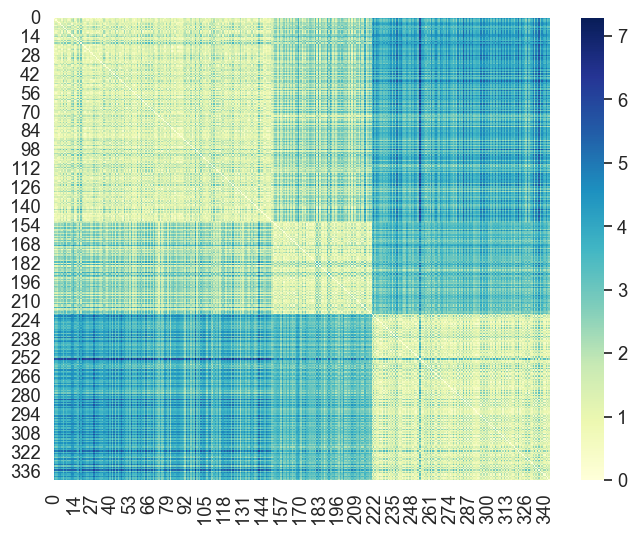

In [813]:
plt.figure(figsize=(8, 6))
df_std_distance = pd.DataFrame(distance_std, index = df_std.index, columns = datos_estandarizadas.index)
sns.heatmap(df_std_distance , annot=False , cmap="YlGnBu", fmt=".1f")
plt.show()

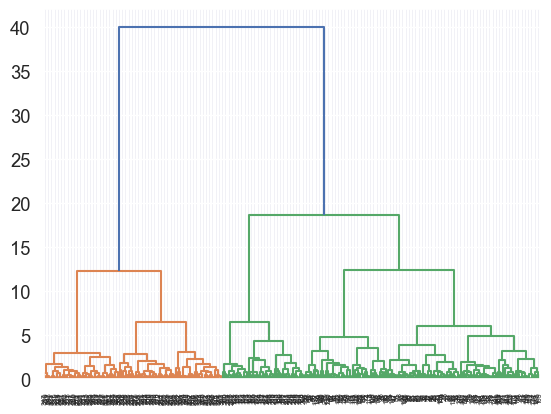

In [814]:
import scipy.cluster.hierarchy as sch 
import matplotlib.pyplot as plt
# Calculate the linkage matrix
linkage_matrix = sch.linkage(datos_estandarizadas , method='ward') 
# You can choose a different linkage method if needed
# Create the dendrogram
dendrogram = sch.dendrogram(linkage_matrix)
# Display the dendrogram
plt.show()

In [815]:
# Assign data points to 4 clusters
from scipy.cluster.hierarchy import fcluster 
num_clusters = 3
cluster_assignments = fcluster(linkage_matrix , num_clusters , criterion='maxclust')
# Display the cluster assignments
print("Cluster Assignments:", cluster_assignments)
# Display the dendrogram
plt.show()

Cluster Assignments: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 2 2 2 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 2 2 3 2 3 2
 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 3 2 2 2 2 3 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


In [816]:
# Create a new column ’Cluster’ and assign the ’ cluster_assignments’ values to it
datos_estandarizadas['Cluster4'] = cluster_assignments
# Now ’df’ contains a new column ’Cluster’ with the cluster assignments
print(datos_estandarizadas["Cluster4"])

0      3
1      3
2      3
4      3
5      3
      ..
338    1
340    1
341    1
342    1
343    1
Name: Cluster4, Length: 342, dtype: int32


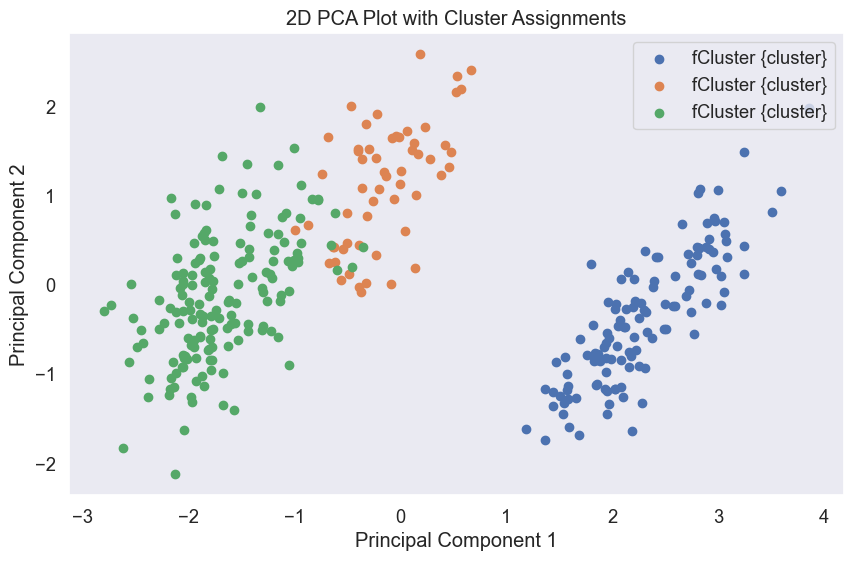

In [817]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Assuming ’df’ is your original DataFrame with data # ’cluster_assignments’ contains cluster assignments
# Step 1: Perform PCA
pca = PCA(n_components=2) 
principal_components = pca.fit_transform(datos_estandarizadas)
# Create a new DataFrame for the 2D principal components
df_pca = pd.DataFrame(data=principal_components , columns=['PC1', 'PC2'])
# Step 2: Create a scatter plot with colors for clusters
plt.figure(figsize=(10, 6))
# Loop through unique cluster assignments and plot data points withthe same color
for cluster in np.unique(cluster_assignments):
    plt.scatter(df_pca.loc[cluster_assignments == cluster , 'PC1'],

    df_pca.loc[cluster_assignments == cluster , 'PC2'],
    label='fCluster {cluster}')
plt.title("2D PCA Plot with Cluster Assignments") 
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2") 
plt.legend()
plt.grid() 
plt.show()

In [818]:
from sklearn.cluster import KMeans
# Set the number of clusters (k=4)
k=3
# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=0)
# Fit the KMeans model to your standardized data
kmeans.fit(datos_estandarizadas)
# Get the cluster labels for your data
kmeans_cluster_labels = kmeans.labels_

In [819]:
kmeans_cluster_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

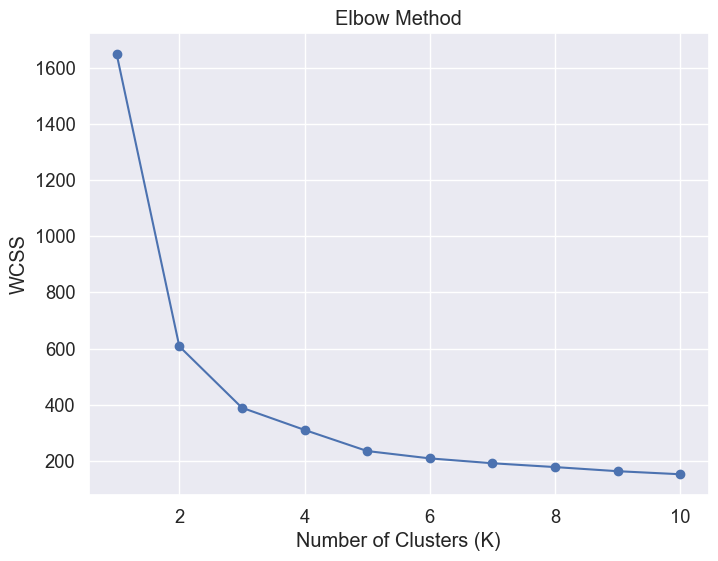

In [820]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Create an array to store the WCSS values for different values of K: 
wcss = []
for k in range(1, 11): # You can choose a different range of K values
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_estandarizadas)
    wcss.append(kmeans.inertia_) # Inertia is the WCSS value 
    #Trace los valores de WCSS frente al n m e r o de grupos (K) ybusque el punto "codo":
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True) 
plt.show()

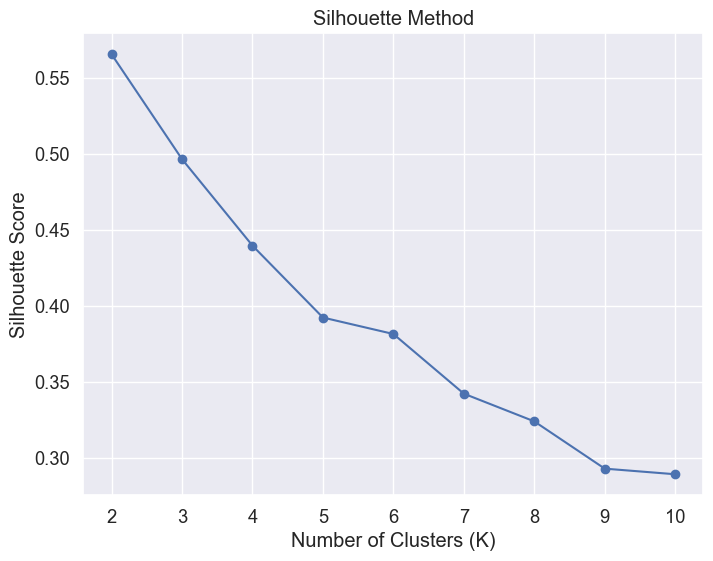

In [821]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Create an array to store silhouette scores for different values of K

silhouette_scores = []

#Run K-means clustering for a range of K values and calculate the silhouette score for each K:

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_estandarizadas)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(datos_estandarizadas, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [822]:
from sklearn.metrics import silhouette_samples
# Assuming 'df_std_distance' is your standardized data and '4' is the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(datos_estandarizadas)
labels = kmeans.labels_

silhouette_values = silhouette_samples(datos_estandarizadas, labels)
silhouette_values

array([ 0.53104367,  0.53523842,  0.4551602 ,  0.54225478,  0.39026734,
        0.5524987 ,  0.31628988,  0.57091001,  0.23804411,  0.56583214,
        0.54761932,  0.44774896,  0.34693944,  0.34197557,  0.60148905,
        0.5101075 ,  0.09489523,  0.57360978,  0.11619909,  0.49882932,
        0.55546256,  0.56614736,  0.56477861,  0.51660278,  0.5773968 ,
        0.4939647 ,  0.49075224,  0.45511206,  0.44445007,  0.46016093,
        0.53464937,  0.54669745,  0.45149015,  0.53608717,  0.28765201,
        0.45428457,  0.38528295,  0.51880948,  0.35098007,  0.56342598,
        0.43084811,  0.56217804, -0.03011562,  0.52622394,  0.37400986,
        0.4382201 ,  0.48886243,  0.60483783,  0.15370006,  0.55585437,
        0.42754226,  0.59600635,  0.2108268 ,  0.5318693 ,  0.43638048,
        0.5701467 ,  0.46086508,  0.4813681 ,  0.54257791,  0.55105632,
        0.17291529,  0.56802557,  0.42164965,  0.5110923 ,  0.40022505,
        0.49075267,  0.40408546,  0.51907478,  0.20401488,  0.55

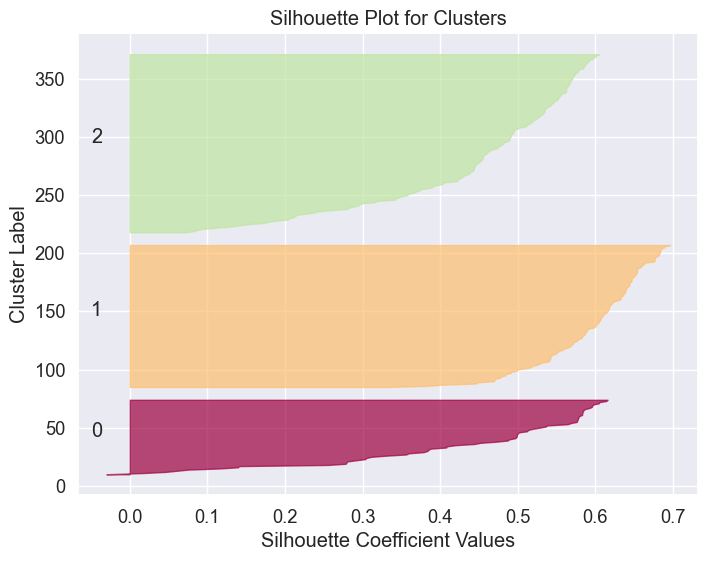

In [823]:
plt.figure(figsize=(8, 6))

y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.get_cmap("Spectral")(float(i) / 3)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Plot for Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.grid(True)
plt.show()

#mayor coheficiente el 6, ancho es cantidad de datos

In [824]:
# Add the labels as a new column to the DataFrame
datos_estandarizadas['label'] = labels
# Sort the DataFrame by the "label" column
datos_estandarizadas_sort = datos_estandarizadas.sort_values(by="label")
# Set the 'A' column as the index
PAIS_labels = datos_estandarizadas.index
datos_estandarizadas = datos_estandarizadas.set_index(PAIS_labels)
datos_estandarizadas_sort['label']

171    0
152    0
193    0
194    0
195    0
      ..
103    2
102    2
101    2
108    2
0      2
Name: label, Length: 342, dtype: int32

In [825]:
# Group the data by the 'label' column and calculate the mean of each group
cluster_centroids = datos_estandarizadas_sort.groupby('label').mean()
cluster_centroids.round(2)
# 'cluster_centroids' now contains the centroids of each cluster

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Cluster4
label,,,,,
0,0.97,0.77,-0.28,-0.47,2.12
1,0.66,-1.10,1.16,1.09,1.00
2,-0.94,0.55,-0.81,-0.68,3.00


In [826]:
# Add the labels as a new column to the DataFrame
datos_estandarizadas['label'] = labels
# Sort the DataFrame by the "label" column
df_sort = datos_estandarizadas.sort_values(by="label")

# Group the data by the 'label' column and calculate the mean of each group
cluster_centroids_orig = df_sort.groupby('label').mean()
cluster_centroids_orig.round(2)
# 'cluster_centroids' now contains the centroids of each cluster

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Cluster4
label,,,,,
0,0.97,0.77,-0.28,-0.47,2.12
1,0.66,-1.10,1.16,1.09,1.00
2,-0.94,0.55,-0.81,-0.68,3.00


In [827]:
datos_estandarizadas

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Cluster4,label
0,-0.884499,0.785449,-1.418347,-0.564142,3,2
1,-0.811126,0.126188,-1.062250,-0.501703,3,2
2,-0.664380,0.430462,-0.421277,-1.188532,3,2
4,-1.324737,1.089724,-0.563715,-0.938776,3,2
5,-0.847812,1.748985,-0.777373,-0.689020,3,2
...,...,...,...,...,...,...
338,0.601305,-1.750171,0.931890,0.903175,1,1
340,0.527932,-1.445897,1.003109,0.809516,1,1
341,1.188289,-0.735923,1.501644,1.933419,1,1
342,0.234440,-1.192335,0.789451,1.246590,1,1


In [828]:
# Crea una instancia de ACP con las dos primeras componentes que nos interesan y aplicar a los datos.
pca = PCA(n_components=2)
fit = pca.fit(datos_estandarizadas)
# Obtener los autovectores asociados a cada componente principal y transponerlos.
autovectores = pd.DataFrame(pca.components_.T, 
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in numericas])

# Obtener los autovalores asociados a cada componente principal.
autovalores = fit.explained_variance_
# Obtener la varianza explicada por cada componente principal como un porcentaje de la varianza total.
var_explicada = fit.explained_variance_ratio_*100
# Calcular la varianza explicada acumulada a medida que se agregan cada componente principal.
var_acumulada = np.cumsum(var_explicada)
# Crear un DataFrame de pandas con los datos anteriores y establecer  ́ındice .
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada , 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range (1, fit.n_components_+1)])
tabla

autovectores

ValueError: Shape of passed values is (6, 2), indices imply (4, 2)